In [1]:
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F # Needed for the attention layer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import time
import torch.nn.functional as F

# Imports for plotting



In [2]:
#obtain data from file
adata =  sc.read_h5ad("data/Norman_2019.h5ad")  # replace with your path

#export data from sc.read
ddata = adata.X.toarray()
labels = adata.obs['perturbation_name'].to_numpy()
parsed_labels = [p.split('+') if p != 'control' else [] for p in labels]

#multilabel encode the data 
mlb = MultiLabelBinarizer()
labels_int = mlb.fit_transform(parsed_labels)

#split data
X_train, X_test, y_train, y_test = train_test_split(
    ddata, 
    labels_int, 
    test_size=0.2, 
    random_state=67, #SIX SEVEENNNNNNNNNN
    #stratify=labels_int
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from attention import AttentiveMLP

input_dim = X_train.shape[1] # Number of genes
num_classes = labels_int[0].size
learning_rate = 0.00026

learning_rate = 0.00026
weight_decay = 1.889e-6
attention_dim = 32  # A reasonable starting size for the attention bottleneck
hidden_dims = [219] # A list containing the size of each hidden layer. From your Optuna result: 1 layer of size 219.
dropout_p = 0.3
num_epochs = 50

model = AttentiveMLP(
    input_dim=input_dim,
    num_classes=num_classes,
    attention_dim=attention_dim,
    hidden_dims=hidden_dims,
    dropout_p=dropout_p
)
criterion = nn.BCEWithLogitsLoss() # Best for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 2e-6)

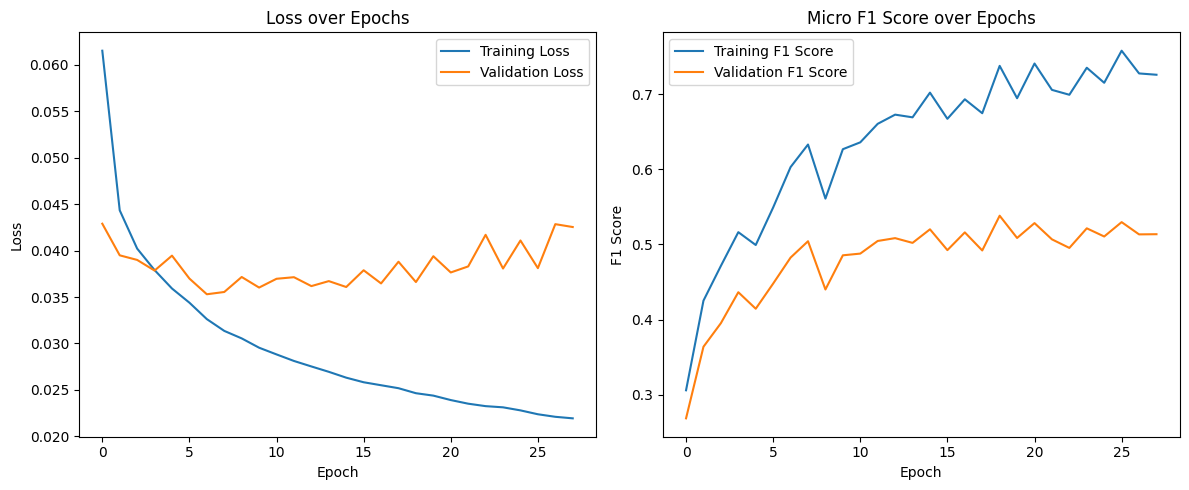

Epoch [28/50], Train Loss: 0.0219, Val Loss: 0.0425, Val F1: 0.5136


KeyboardInterrupt: 

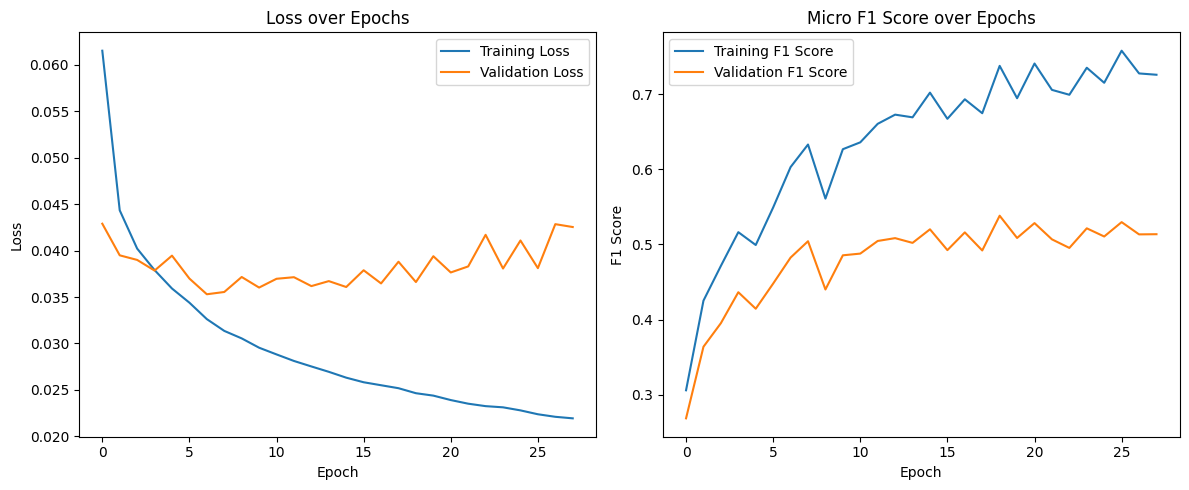

In [4]:



# --- 2. Set Hyperparameters & Initialize Model ---

# We'll use the best parameters from your previous Optuna search as a starting point
# and add a parameter for the attention layer's complexity.

# Instantiate the new model with these parameters

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# --- 3. Run the Training and Plotting Loop ---
# (This is your exact code from before)

train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
display(fig)

for epoch in range(num_epochs):
    model.train()
    current_train_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
    train_losses.append(current_train_loss / len(train_loader))

    model.eval()
    current_test_loss = 0.0
    all_train_preds, all_train_labels = [], []
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_test_preds.append(preds.numpy())
            all_test_labels.append(labels.numpy())
        
        for inputs, labels in train_loader:
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.append(preds.numpy())
            all_train_labels.append(labels.numpy())
        
    test_losses.append(current_test_loss / len(test_loader))
    
    train_f1 = f1_score(np.vstack(all_train_labels), np.vstack(all_train_preds), average='micro')
    test_f1 = f1_score(np.vstack(all_test_labels), np.vstack(all_test_preds), average='micro')
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    
    ax1.clear()
    ax2.clear()
    
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(test_losses, label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_f1_scores, label='Training F1 Score')
    ax2.plot(test_f1_scores, label='Validation F1 Score')
    ax2.set_title('Micro F1 Score over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    
    fig.tight_layout()
    clear_output(wait=True)
    display(fig)
    time.sleep(0.1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {test_losses[-1]:.4f}, Val F1: {test_f1_scores[-1]:.4f}')

plt.close(fig)
print(f"\nTraining Complete. Final Validation F1 Score: {test_f1_scores[-1]:.4f}")

In [5]:
# --- Standard Imports ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import scanpy as sc

# --- The Hyperparameter Optimization Library ---
import optuna

# --- 1. Data Preparation (Done Once) ---
# This section should contain your actual data loading.
# For this example, we use dummy data so the script is runnable.
print("Step 1: Preparing data...")
n_obs, n_vars, n_categories = 1000, 50, 10
categories = [f'g{i}' for i in range(n_categories)]
pert_list = [np.random.choice(categories) if np.random.rand() > 0.1 else f'{np.random.choice(categories)}+{np.random.choice(categories)}' for _ in range(n_obs - 100)]
pert_list.extend(['control'] * 100)
np.random.shuffle(pert_list)
dummy_obs = pd.DataFrame({'perturbation_name': pert_list})
dummy_X_pca = np.random.rand(n_obs, n_vars)
adata = sc.AnnData(X=np.zeros((n_obs, 2000)), obs=dummy_obs)
adata.obsm['X_pca'] = dummy_X_pca

X = adata.obsm['X_pca']
perturbation_series = adata.obs['perturbation_name']
parsed_labels = [p.split('+') if p != 'control' else [] for p in perturbation_series]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(parsed_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

input_dim = X_train.shape[1]
num_classes = y_train.shape[1]
print("Data preparation complete.")

# --- 2. Define the Tunable Model Architecture ---

class FeatureAttention(nn.Module):
    """
    An improved FeatureAttention module where the activation and residual connection
    are configurable, making them tunable hyperparameters.
    """
    def __init__(self, input_dim, attention_dim, activation_type='softmax', use_residual=True):
        super(FeatureAttention, self).__init__()
        self.activation_type = activation_type
        self.use_residual = use_residual
        self.attention_net = nn.Sequential(
            nn.Linear(input_dim, attention_dim),
            nn.ReLU(),
            nn.Linear(attention_dim, input_dim)
        )

    def forward(self, x):
        attention_logits = self.attention_net(x)
        
        if self.activation_type == 'softmax':
            attention_weights = F.softmax(attention_logits, dim=1)
        elif self.activation_type == 'sigmoid':
            attention_weights = torch.sigmoid(attention_logits)
        else:
            raise ValueError("Invalid activation type for attention")

        attended_features = x * attention_weights
        
        if self.use_residual:
            return attended_features + x
        else:
            return attended_features

class AttentiveMLP(nn.Module):
    """
    The main model that takes an Optuna trial to dynamically build its architecture,
    including the improved, tunable attention mechanism.
    """
    def __init__(self, trial, input_dim, num_classes):
        super(AttentiveMLP, self).__init__()
        
        # --- Tune the Attention Layer ---
        attention_dim = trial.suggest_int('attention_dim', 16, 64)
        activation_type = trial.suggest_categorical('attention_activation', ['softmax', 'sigmoid'])
        use_residual = trial.suggest_categorical('use_residual', [True, False])
        
        self.attention = FeatureAttention(input_dim, attention_dim, activation_type, use_residual)
        
        # --- Tune the MLP Layers ---
        mlp_layers = []
        n_layers = trial.suggest_int('n_layers', 1, 3)
        in_features = input_dim
        
        for i in range(n_layers):
            out_features = trial.suggest_int(f'n_units_l{i}', 32, 256, log=True)
            mlp_layers.append(nn.Linear(in_features, out_features))
            mlp_layers.append(nn.ReLU())
            dropout_p = trial.suggest_float(f'dropout_l{i}', 0.1, 0.5)
            mlp_layers.append(nn.Dropout(dropout_p))
            in_features = out_features
        
        mlp_layers.append(nn.Linear(in_features, num_classes))
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x):
        attended_x = self.attention(x)
        output = self.mlp(attended_x)
        return output

# --- 3. Define the Objective Function for Optuna ---

def objective(trial):
    """The main function Optuna will call for each trial."""
    
    model = AttentiveMLP(trial, input_dim, num_classes)
    
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    num_epochs = 50
    patience = 10
    patience_counter = 0
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        all_test_preds, all_test_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_test_preds.append(preds.numpy())
                all_test_labels.append(labels.numpy())
        
        val_f1 = f1_score(np.vstack(all_test_labels), np.vstack(all_test_preds), average='micro')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
        
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if patience_counter >= patience:
            break

    return best_val_f1

# --- 4. Run the Study ---
print("\nStep 2: Starting hyperparameter optimization study...")
study = optuna.create_study(direction='maximize')
# Let's run for 100 trials to get a thorough search
study.optimize(objective, n_trials=100)
print("Study complete.")

# --- 5. Print the Best Results ---
print("\n--- Study Results ---")
print("Number of finished trials: ", len(study.trials))

print("\nBest trial:")
trial = study.best_trial
print(f"  Value (Best F1 Score): {trial.value:.4f}")

print("  Best Hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


Step 1: Preparing data...


[I 2025-10-08 08:35:55,657] A new study created in memory with name: no-name-4b6fbbf6-0f3d-443d-a161-e03a00062bb2
[I 2025-10-08 08:35:55,834] Trial 0 finished with value: 0.0 and parameters: {'attention_dim': 43, 'attention_activation': 'sigmoid', 'use_residual': False, 'n_layers': 3, 'n_units_l0': 141, 'dropout_l0': 0.33046528237984124, 'n_units_l1': 219, 'dropout_l1': 0.11096478406349766, 'n_units_l2': 141, 'dropout_l2': 0.1651133970071466, 'lr': 0.0005695262380495537, 'weight_decay': 1.345491974398508e-06}. Best is trial 0 with value: 0.0.


Data preparation complete.

Step 2: Starting hyperparameter optimization study...


[I 2025-10-08 08:35:55,988] Trial 1 finished with value: 0.17152373022481265 and parameters: {'attention_dim': 37, 'attention_activation': 'softmax', 'use_residual': False, 'n_layers': 3, 'n_units_l0': 32, 'dropout_l0': 0.20235027388128884, 'n_units_l1': 52, 'dropout_l1': 0.14684966885362968, 'n_units_l2': 254, 'dropout_l2': 0.4446764976808319, 'lr': 1.5840640861327877e-05, 'weight_decay': 1.0130308743852277e-06}. Best is trial 1 with value: 0.17152373022481265.
[I 2025-10-08 08:35:56,152] Trial 2 finished with value: 0.14185814185814186 and parameters: {'attention_dim': 58, 'attention_activation': 'softmax', 'use_residual': False, 'n_layers': 3, 'n_units_l0': 72, 'dropout_l0': 0.11387471641676124, 'n_units_l1': 34, 'dropout_l1': 0.3780732545234826, 'n_units_l2': 73, 'dropout_l2': 0.10287022591452583, 'lr': 0.0001721512626547446, 'weight_decay': 3.819447589532766e-06}. Best is trial 1 with value: 0.17152373022481265.
[I 2025-10-08 08:35:56,319] Trial 3 finished with value: 0.1687951138

Study complete.

--- Study Results ---
Number of finished trials:  100

Best trial:
  Value (Best F1 Score): 0.2069
  Best Hyperparameters: 
    attention_dim: 24
    attention_activation: sigmoid
    use_residual: False
    n_layers: 1
    n_units_l0: 128
    dropout_l0: 0.42673900025554384
    lr: 3.556443306079082e-05
    weight_decay: 9.770971601150827e-05
